In [16]:
%%capture
!pip install arviz
!pip install pymc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pymc as pm
import arviz as az

In [17]:
!pip install graphviz
import graphviz

In [18]:
#Load data
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTAIkE0WP7eDyzowDqmIPF8oQdONu4_ZmNeARcx1M74Rqq5t-b2Uo-CH8Arm8153RH81o6XO6Pw3mfb/pub?output=csv')

# INTRODUCTION

## Data cleaning steps

### Aggregate total revenue

In [19]:
df['total_revenue'] = (
    df['vat_net_refunds'] + df['earnings'] +
    df['contributions_social_security_contributions '] +
    df['debits_credits'] + df['personal_property'] +
    df['internal_taxes'] + df['fuels'] +
    df['export_rights'] + df['import_rights'] + df['rest_tributary']
)


### Modify unit of measurement

In [20]:
data_x = df['total_revenue']/ 1000000
data_y = df['wages']/ 1000000

### Descriptive stats summary

In [21]:
# Creating a DataFrame with `data_x` and `data_y`
df_summary = pd.DataFrame({
    'Total Revenue (Trillions)': data_x,
    'Wages (Trillions)': data_y
})

# Calculating descriptive statistics
descriptive_stats = df_summary.describe().T  # Transpose for easier reading

# Rounding to 3 decimal places for better readability
descriptive_stats = descriptive_stats.round(3)

# Renaming the columns for a nicely formatted output
descriptive_stats.columns = [
    'Count', 'Mean', 'Std Dev', 'Min', '25%', 'Median', '75%', 'Max'
]

# Display the formatted descriptive statistics
descriptive_stats


Count   Mean  Std Dev    Min    25%  Median    75%  \
Total Revenue (Trillions)  105.0  1.207    1.994  0.096  0.188   0.353  1.129   
Wages (Trillions)          105.0  0.181    0.284  0.017  0.031   0.054  0.171   

                             Max  
Total Revenue (Trillions)  8.676  
Wages (Trillions)          1.378

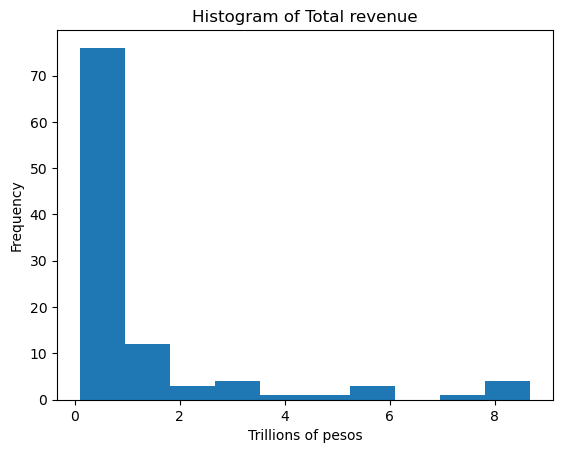

In [22]:
plt.hist(data_x, bins=10)
plt.xlabel('Trillions of pesos')
plt.ylabel('Frequency')
plt.title('Histogram of Total revenue')
plt.show()

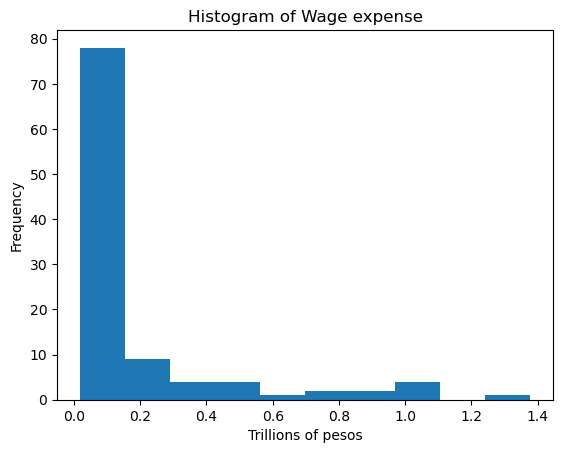

In [23]:
plt.hist(data_y, bins=10)
plt.xlabel('Trillions of pesos')
plt.ylabel('Frequency')
plt.title('Histogram of Wage expense')
plt.show()

### Scatter plot

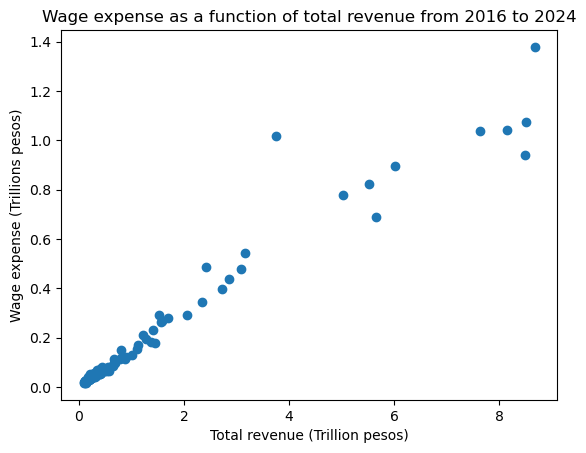

In [24]:
plt.scatter (data_x, data_y)
plt.xlabel('Total revenue (Trillion pesos)')
plt.ylabel('Wage expense (Trillions pesos)')
plt.title('Wage expense as a function of total revenue from 2016 to 2024')
plt.show()

# CREATE MODELS

## Normal likelihood model

### Choosing Priors

#### C0: Intercept of the linear model that related total revenue to the mean of wage expense

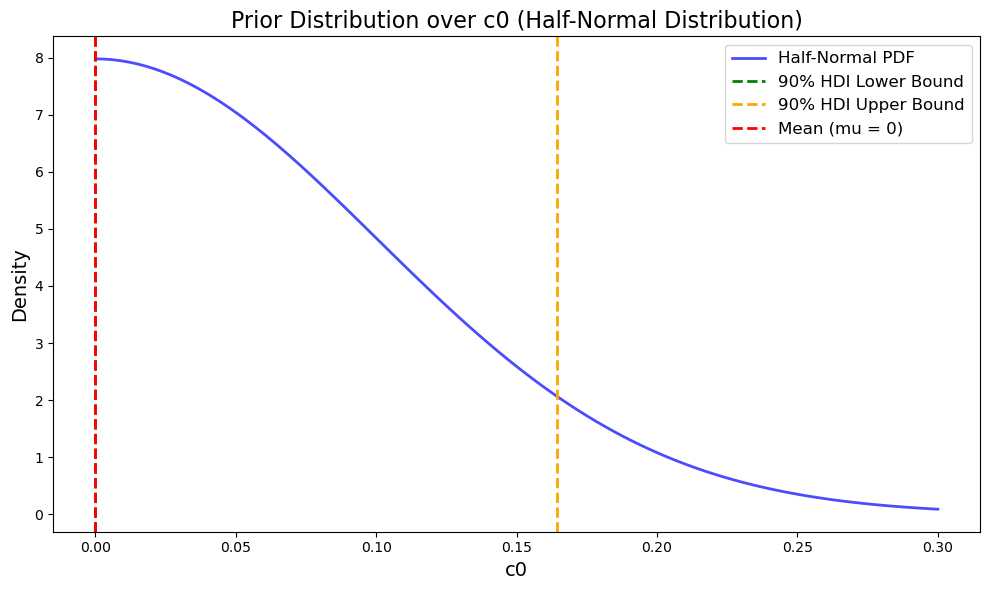

In [25]:
# Parameters for the half-normal distribution
mu = 0
sigma = 0.1

# Generate x values
x = np.linspace(0, mu + 3 * sigma, 100)

# Calculate the half-normal probability density function
y = stats.halfnorm.pdf(x, loc=mu, scale=sigma)

# Generate samples from the half-normal distribution for HDI calculation
samples = stats.halfnorm.rvs(loc=mu, scale=sigma, size=10000)

# Calculate the 90% HDI using ArviZ
hdi_data = az.hdi(samples, hdi_prob=0.90)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, color='blue', lw=2, label='Half-Normal PDF', alpha=0.7)

# Add vertical lines for the HDI bounds
plt.axvline(hdi_data[0], color='green', linestyle='--', lw=2, label='90% HDI Lower Bound')
plt.axvline(hdi_data[1], color='orange', linestyle='--', lw=2, label='90% HDI Upper Bound')

# Add a vertical line for the mean
plt.axvline(mu, color='red', linestyle='--', lw=2, label='Mean (mu = 0)')

# Add title and labels
plt.title('Prior Distribution over c0 (Half-Normal Distribution)', fontsize=16)
plt.xlabel('c0', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for the title and labels
plt.show()

#### C1: Slope of the linear model that related tax revenue to the mean of wage expense

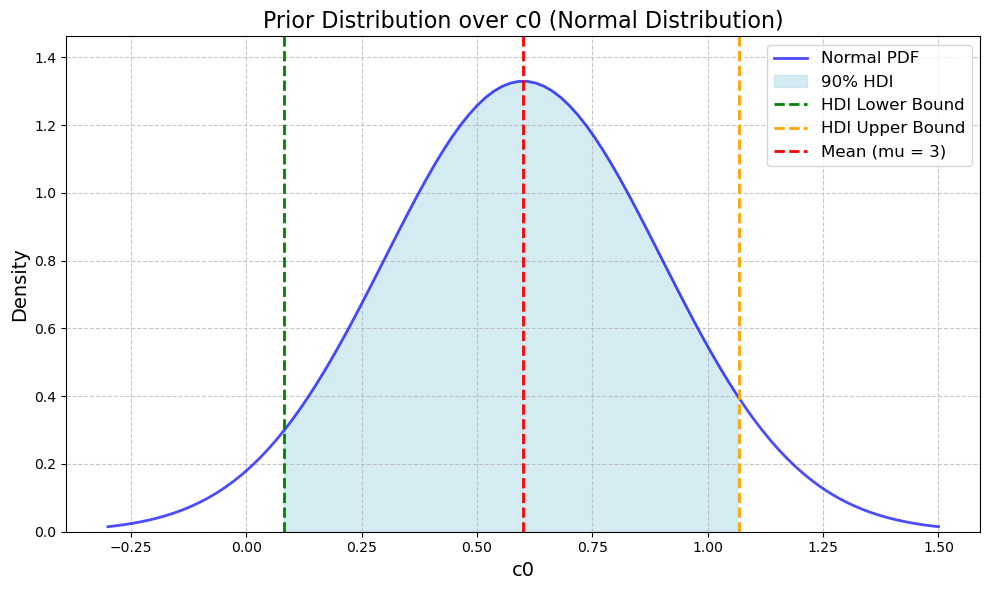

90% HDI: Lower Bound = 0.08117332339743188, Upper Bound = 1.068115232696523


In [26]:
# Parameters for the normal distribution
mu = 0.6  # Mean
sigma = 0.3  # Standard deviation

# Generate x values
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)

# Calculate the normal probability density function
y = stats.norm.pdf(x, loc=mu, scale=sigma)

# Generate samples from the normal distribution for HDI calculation
samples = stats.norm.rvs(loc=mu, scale=sigma, size=10000)

# Calculate the 90% HDI using ArviZ
hdi_data = az.hdi(samples, hdi_prob=0.90)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, color='blue', lw=2, label='Normal PDF', alpha=0.7)

# Shade the area for the HDI
plt.fill_between(x, y, where=(x >= hdi_data[0]) & (x <= hdi_data[1]),
                 color='lightblue', alpha=0.5, label='90% HDI')

# Add vertical lines for the HDI bounds
plt.axvline(hdi_data[0], color='green', linestyle='--', lw=2, label='HDI Lower Bound')
plt.axvline(hdi_data[1], color='orange', linestyle='--', lw=2, label='HDI Upper Bound')

# Add a vertical line for the mean
plt.axvline(mu, color='red', linestyle='--', lw=2, label='Mean (mu = 3)')

# Add title and labels
plt.title('Prior Distribution over c0 (Normal Distribution)', fontsize=16)
plt.xlabel('c0', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)

# Set y-axis limits
plt.ylim(0, max(y) * 1.1)  # Adjust this value based on your needs

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for the title and labels
plt.show()
# Print HDI values
print(f"90% HDI: Lower Bound = {hdi_data[0]}, Upper Bound = {hdi_data[1]}")

#### Sigma: The uncertainty in the likelihood's mean

Define functions for sampling diagnostic

In [27]:
# Loop through models stored in normal_models for diagnostics
def plot_diagnostics(model, inference):
    # Summary statistics
    summary = az.summary(inference, var_names="~mu")
    print(summary);

    # Plot rank
    az.plot_rank(inference, var_names="~mu");

    # Pair plot
    az.plot_pair(inference,
                 marginals=True,
                 var_names="~mu",
                 kind=["scatter", "kde"],
                 scatter_kwargs={"color": "C0", "alpha": 0.1},
                 marginal_kwargs={"kind": "kde", "color": "C0"},
                 kde_kwargs={"contour_kwargs": {"colors": "k", 'alpha': 1}});

### Normal Linear model

#### Define PyMC model

In [28]:
print('Fitting Normal linear model')
with pm.Model() as normal_linear_model:
    intercept = pm.HalfNormal('intercept', sigma=0.1)
    slope = pm.Normal('slope', mu=0.6, sigma=0.3)
    sigma = pm.Uniform('sigma', lower=0, upper=0.5)

    # Mutable data for the observed variables
    x = pm.MutableData('revenue', data_x)
    y = pm.MutableData('wage', data_y)

    mu = pm.Deterministic('mu', intercept + slope * x)
    y = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)
    normal_linear_inference = pm.sample(2000,tune=6000, \
                                        target_accept=0.97, random_seed= 42, \
                                        return_inferencedata=True, \
                                        idata_kwargs={"log_likelihood": True})




Fitting Normal linear model


/Users/macbook/anaconda3/lib/python3.11/site-packages/pymc/data.py:317: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

#### Sampling diagnostic

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
slope      0.139  0.003   0.133    0.145        0.0      0.0    3394.0   
intercept  0.014  0.007   0.001    0.025        0.0      0.0    2773.0   
sigma      0.065  0.005   0.056    0.073        0.0      0.0    4626.0   

           ess_tail  r_hat  
slope        4307.0    1.0  
intercept    1970.0    1.0  
sigma        4145.0    1.0  


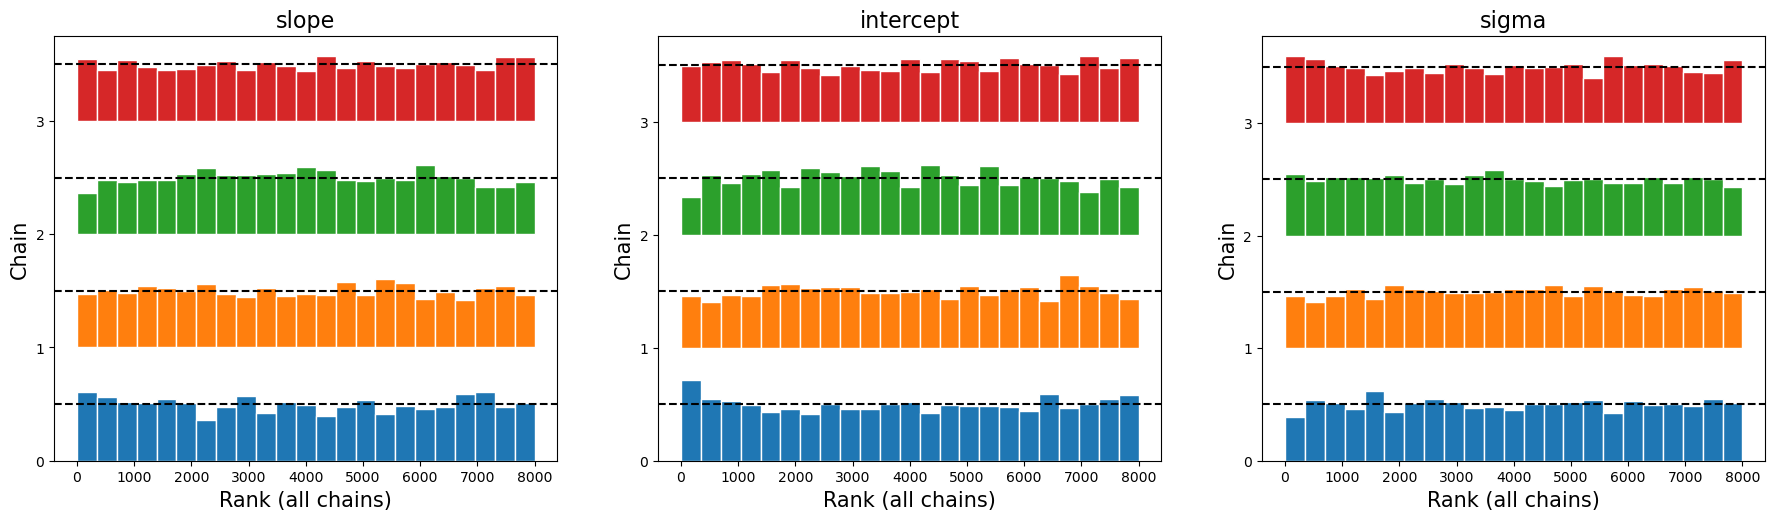

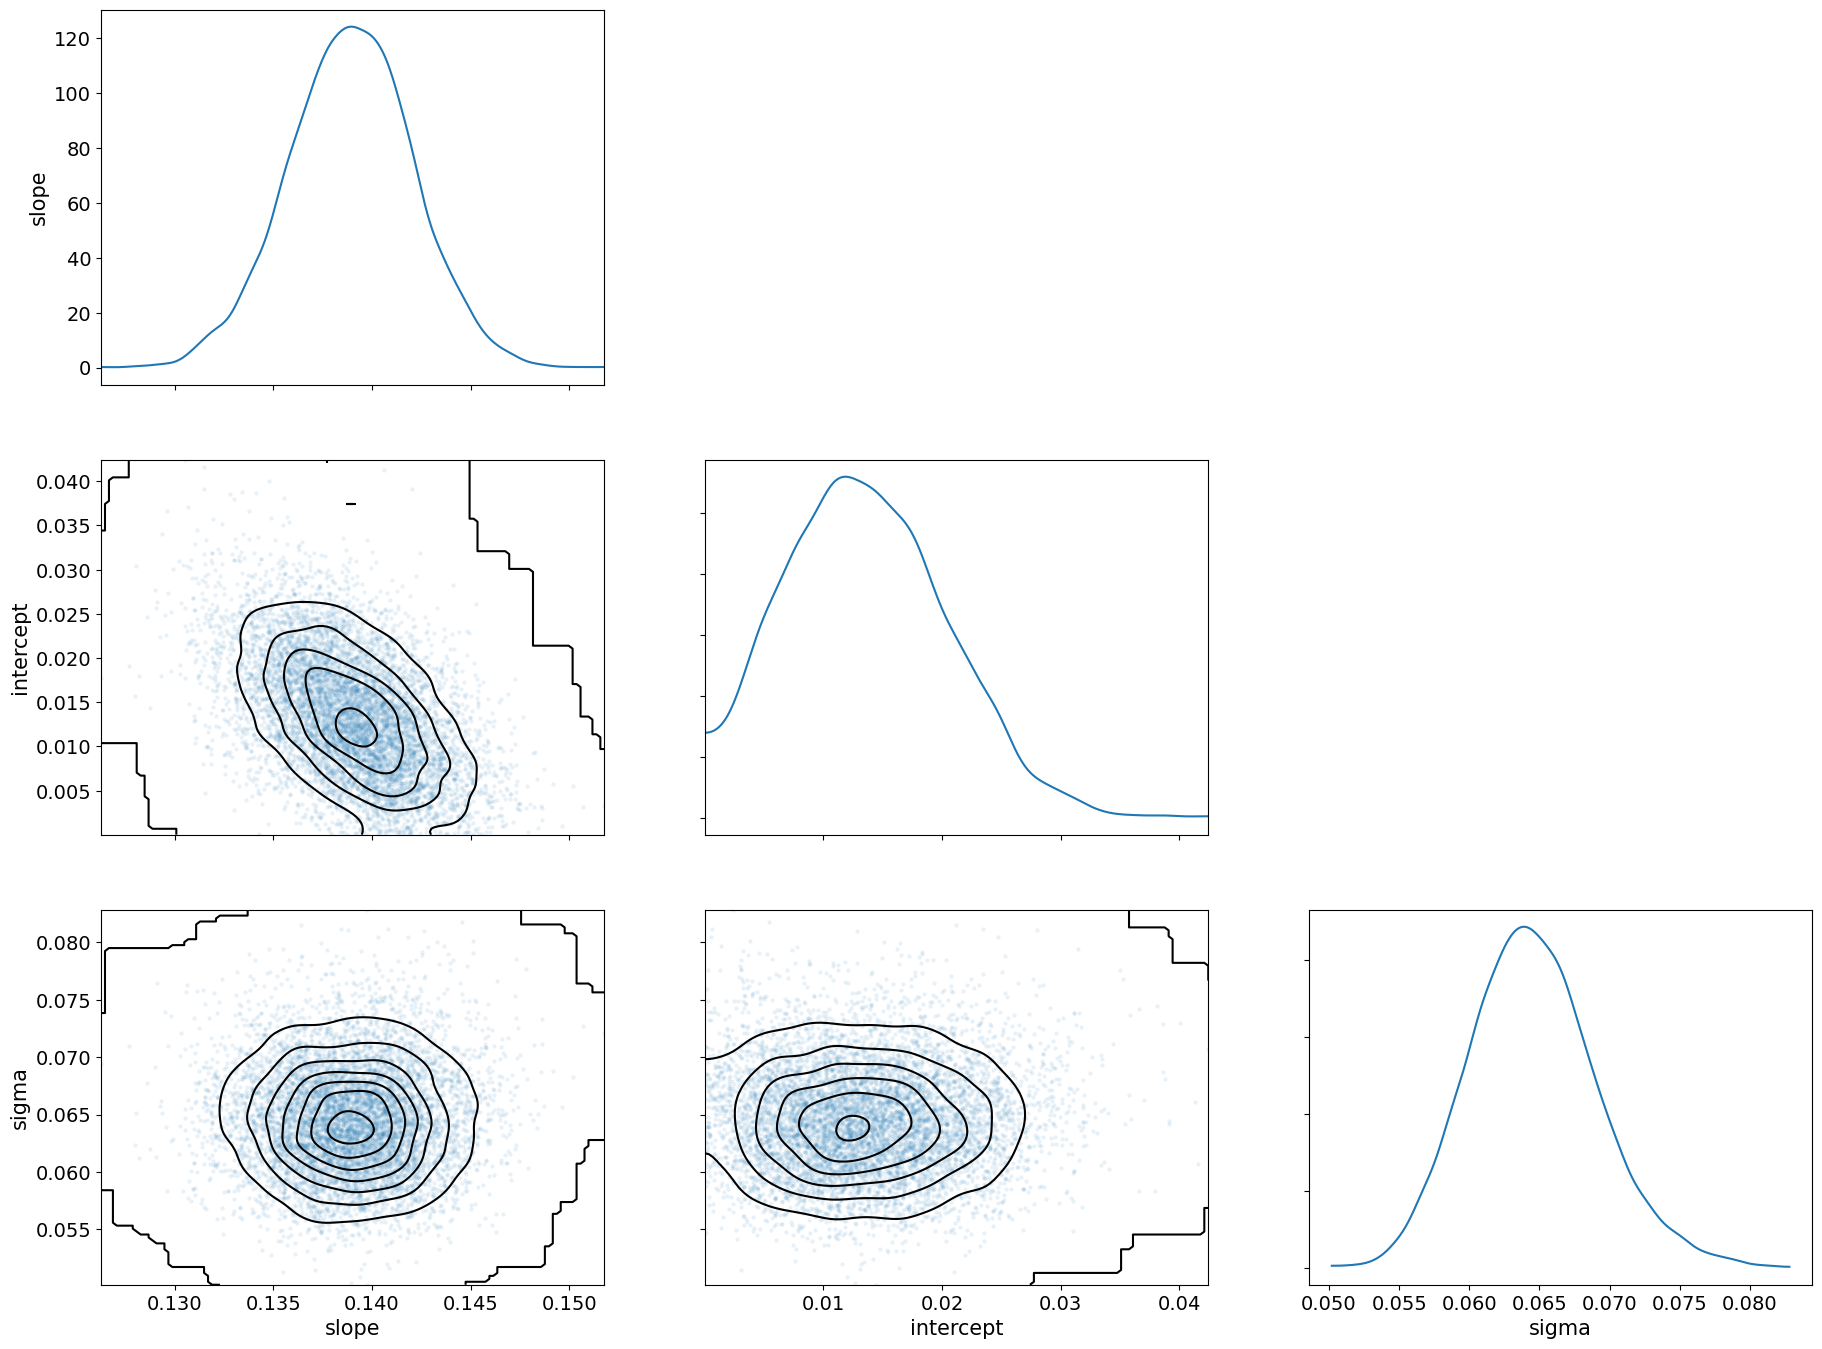

In [29]:
plot_diagnostics (normal_linear_model, normal_linear_inference)

### Normal quadratic model

#### Define PyMC model

In [30]:
print('Fitting quadratic model')
with pm.Model() as normal_quadratic_model:
    intercept = pm.HalfNormal('intercept', sigma=0.1)
    slope = pm.Normal('slope', mu=0.6, sigma=0.3, shape = 2)
    sigma = pm.Uniform('sigma', lower=0, upper=0.5)

    # Mutable data for the observed variables
    x = pm.MutableData('revenue', data_x)
    y = pm.MutableData('wage', data_y)

    mu = pm.Deterministic('mu', intercept + slope[0] * x + slope[1] * x**2)
    y = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)
    normal_quadratic_inference = pm.sample(2000,tune=6000, \
                                        target_accept=0.97, random_seed= 42, \
                                        return_inferencedata=True, \
                                        idata_kwargs={"log_likelihood": True})

Fitting quadratic model


/Users/macbook/anaconda3/lib/python3.11/site-packages/pymc/data.py:317: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

#### Sampling diagnostic

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
slope[0]   0.175  0.008   0.161    0.191        0.0      0.0    2525.0   
slope[1]  -0.005  0.001  -0.007   -0.003        0.0      0.0    2567.0   
intercept  0.004  0.003   0.000    0.010        0.0      0.0    2842.0   
sigma      0.059  0.004   0.051    0.066        0.0      0.0    4120.0   

           ess_tail  r_hat  
slope[0]     3274.0    1.0  
slope[1]     3036.0    1.0  
intercept    2460.0    1.0  
sigma        3856.0    1.0  


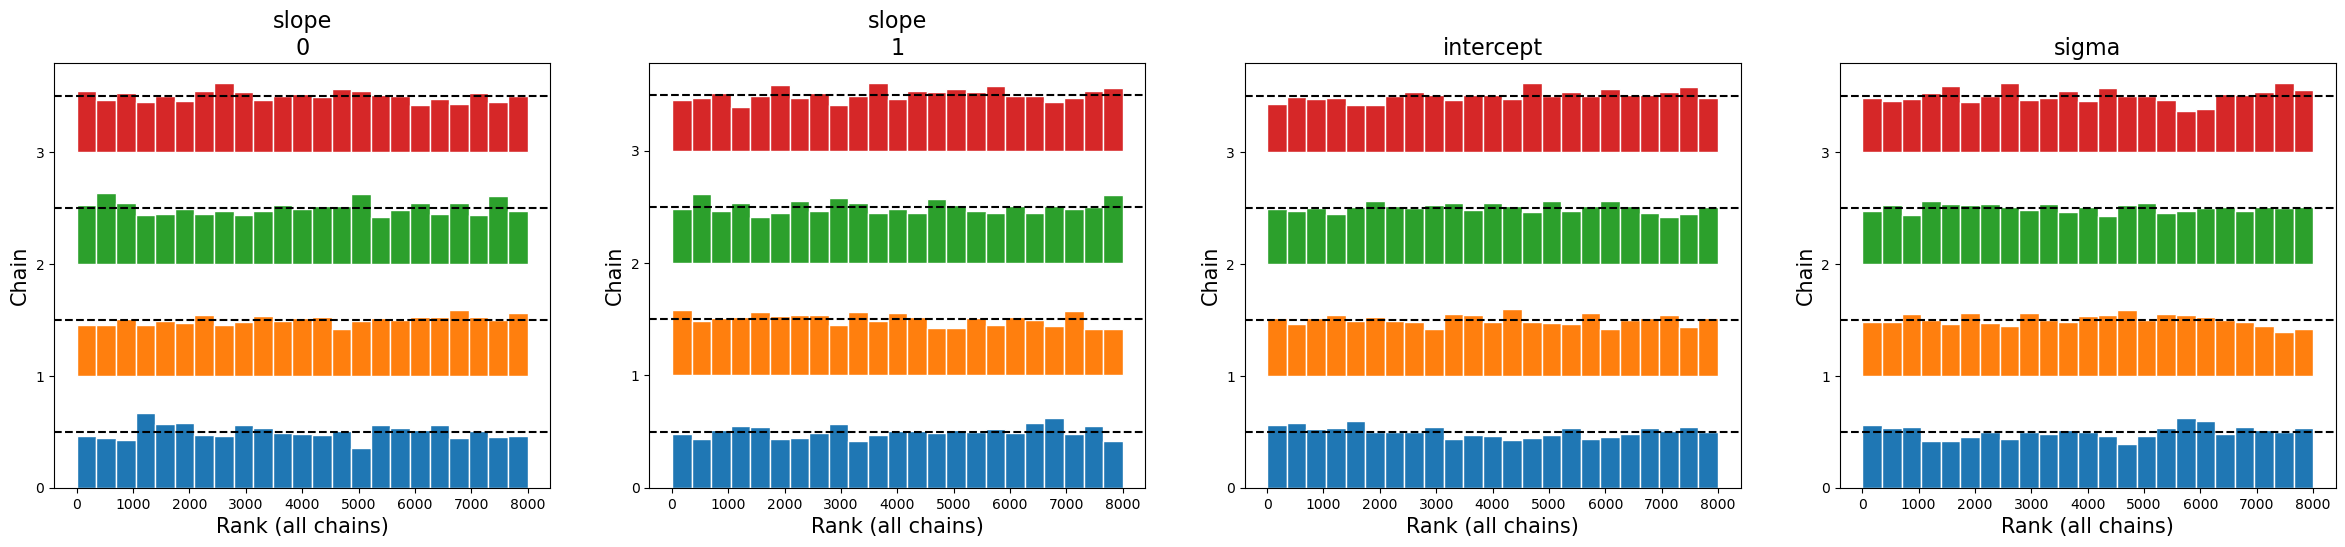

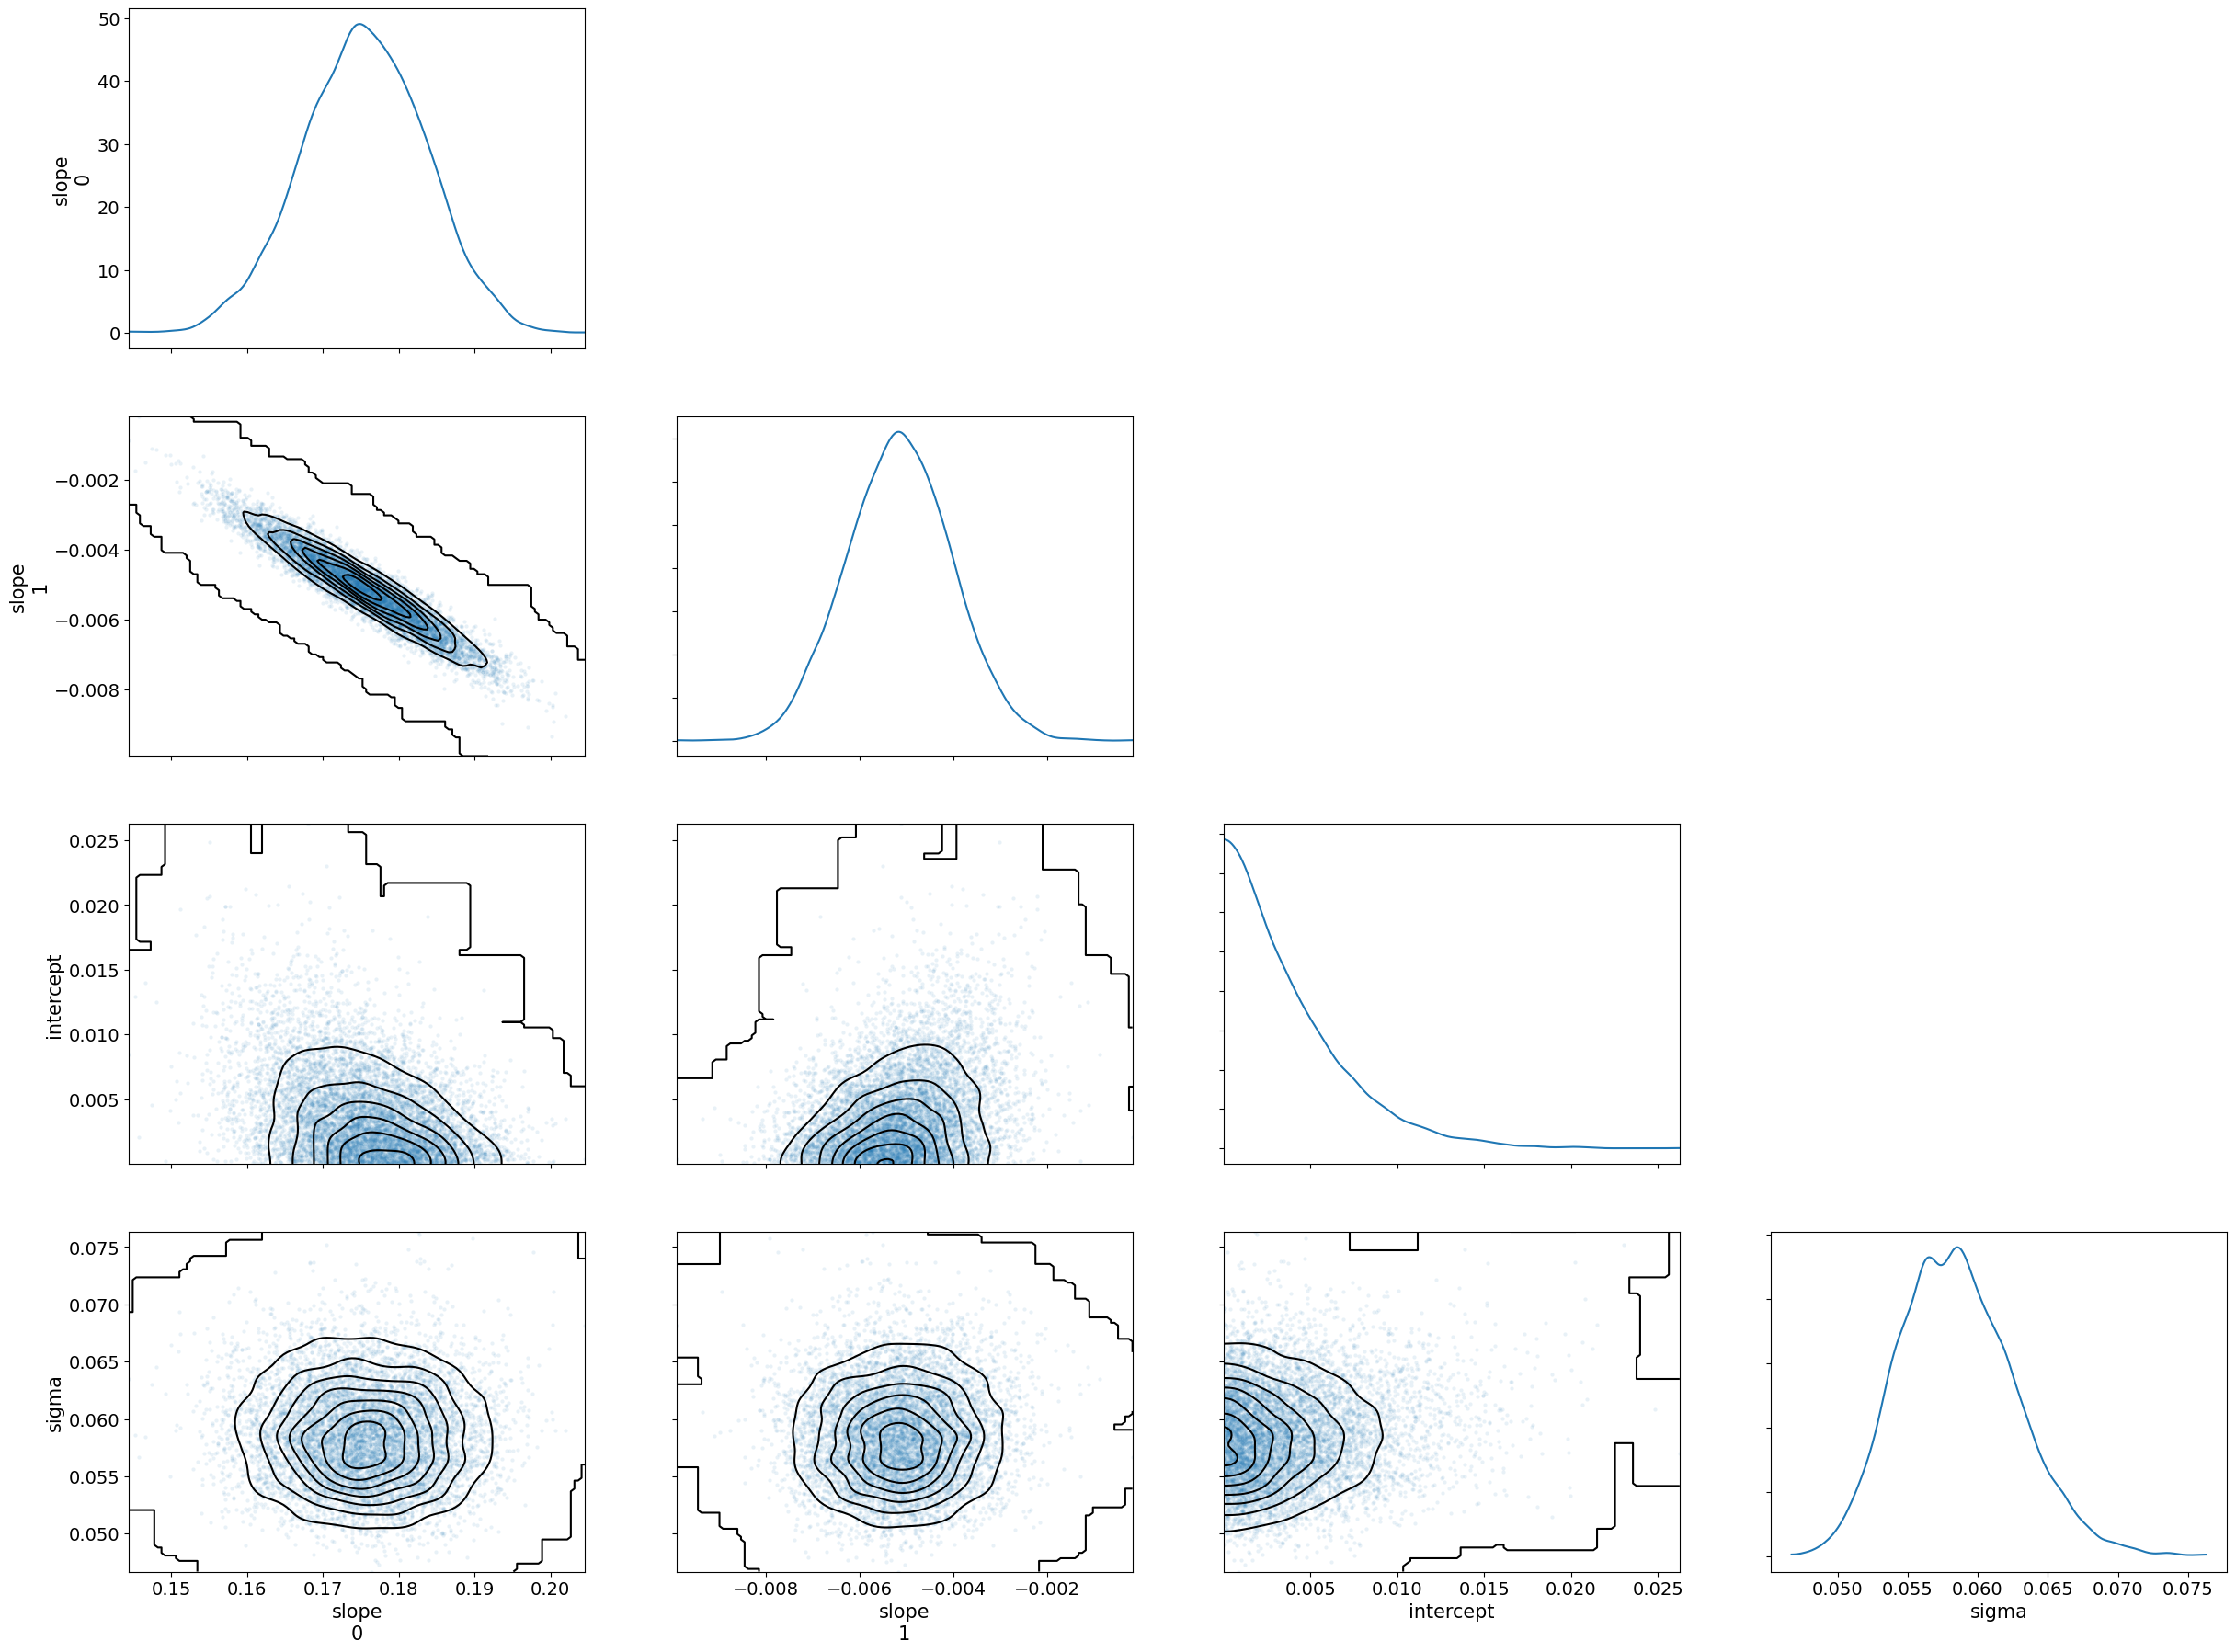

In [31]:
plot_diagnostics (normal_quadratic_model, normal_quadratic_inference)

### Normal cubic model

#### Define PyMC model

In [32]:
print('Fitting normal cubic model')
with pm.Model() as normal_cubic_model:
    intercept = pm.HalfNormal('intercept', sigma=0.1)
    slope = pm.Normal('slope', mu=0.6, sigma=0.3, shape = 3)
    sigma = pm.Uniform('sigma', lower=0, upper=0.5)

    # Mutable data for the observed variables
    x = pm.MutableData('revenue', data_x)
    y = pm.MutableData('wage', data_y)

    mu = pm.Deterministic('mu', intercept + slope[0] * x + slope[1] * x**2 + slope[2] * x**3)
    y = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)
    normal_cubic_inference = pm.sample(2000,tune=6000, \
                                        target_accept=0.97, random_seed= 42, \
                                        return_inferencedata=True, \
                                        idata_kwargs={"log_likelihood": True})

Fitting normal cubic model


/Users/macbook/anaconda3/lib/python3.11/site-packages/pymc/data.py:317: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

#### Sampling diagnostic

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
slope[0]   0.158  0.015   0.129    0.185        0.0      0.0    2588.0   
slope[1]   0.003  0.006  -0.007    0.014        0.0      0.0    2541.0   
slope[2]  -0.001  0.001  -0.002    0.000        0.0      0.0    2688.0   
intercept  0.006  0.005   0.000    0.014        0.0      0.0    2433.0   
sigma      0.059  0.004   0.051    0.067        0.0      0.0    3294.0   

           ess_tail  r_hat  
slope[0]     3176.0    1.0  
slope[1]     3290.0    1.0  
slope[2]     3628.0    1.0  
intercept    2210.0    1.0  
sigma        3608.0    1.0  


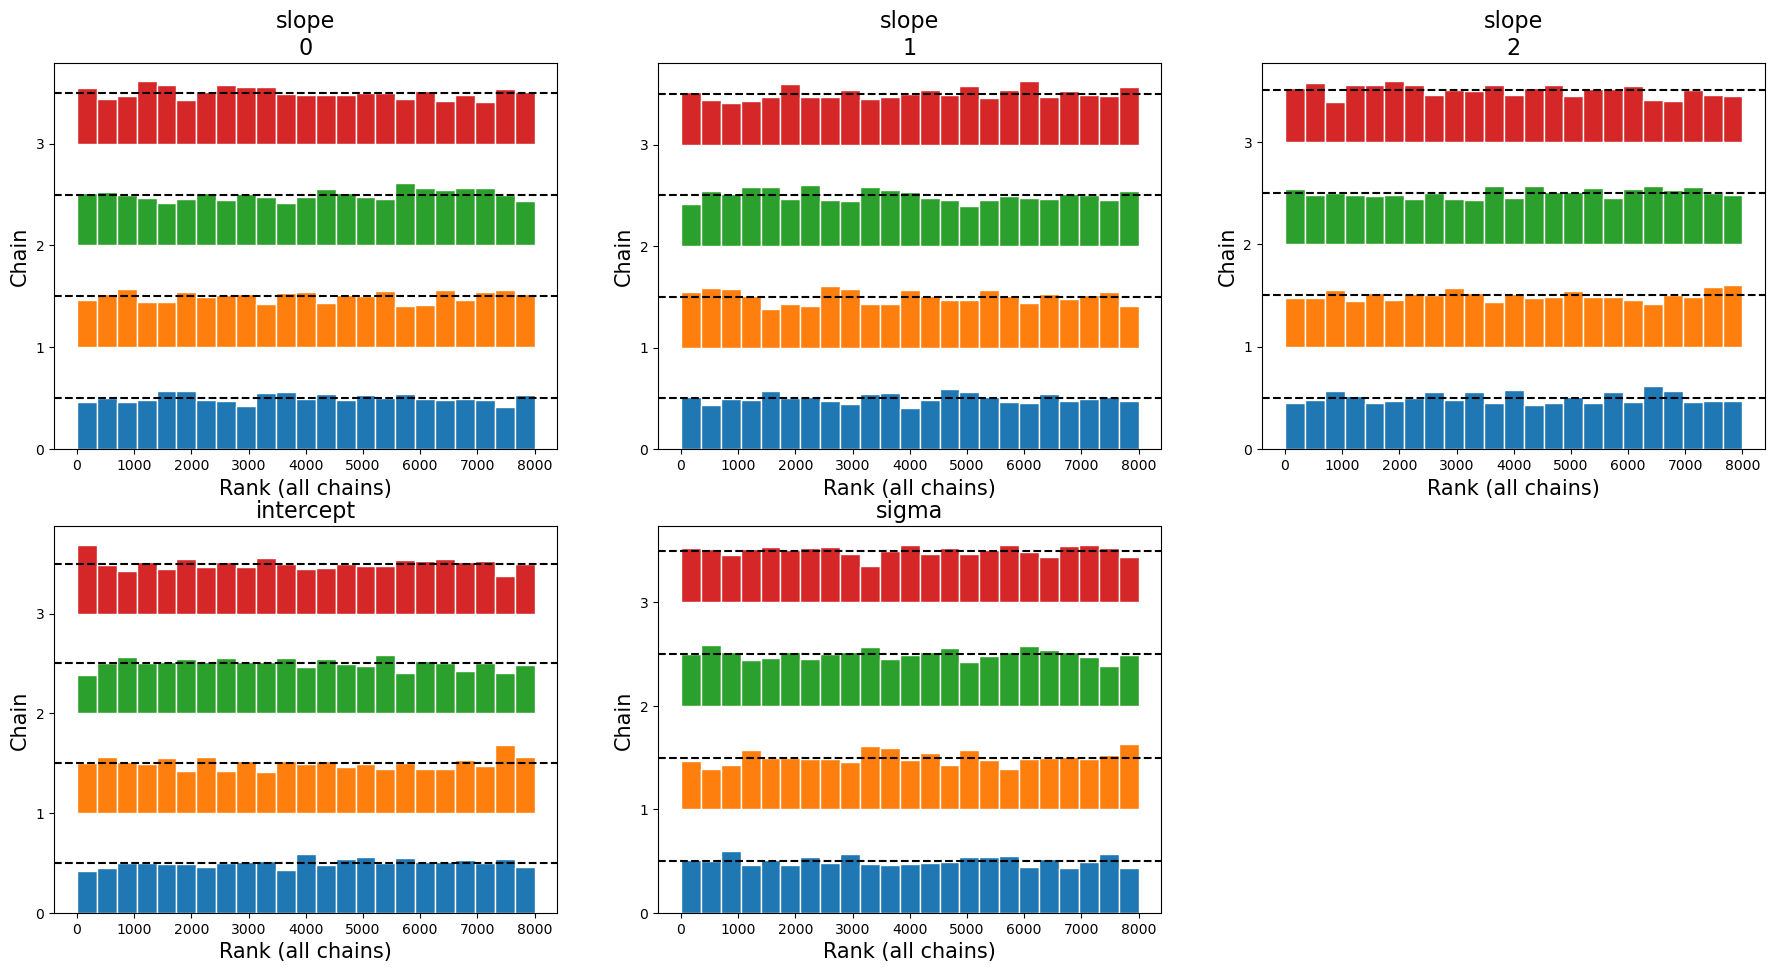

In [33]:
plot_diagnostics (normal_cubic_model, normal_cubic_inference)

# Student T likelihood model

### Student T linear model

#### Define PyMC model

In [34]:
print('Fitting Student T linear model')
with pm.Model() as studentT_linear_model:
    intercept = pm.HalfNormal('intercept', sigma=0.1)
    slope = pm.Normal('slope', mu=0.6, sigma=0.3)
    sigma = pm.Uniform('sigma', lower=0, upper=0.5)
    # Degrees of freedom for the Student's t-distribution
    nu = pm.HalfNormal('nu', sigma=30)
    # Mutable data for the observed variables
    x = pm.MutableData('revenue', data_x)
    y = pm.MutableData('wage', data_y)

    mu = pm.Deterministic('mu', intercept + slope * x)
    y = pm.StudentT('likelihood', nu=nu, mu=mu, sigma=sigma, observed=y)
    studentT_linear_inference = pm.sample(2000,tune=6000, \
                                        target_accept=0.97, random_seed= 42, \
                                        return_inferencedata=True, \
                                        idata_kwargs={"log_likelihood": True})




Fitting Student T linear model


/Users/macbook/anaconda3/lib/python3.11/site-packages/pymc/data.py:317: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

#### Sampling diagnostic

In [35]:
plot_diagnostics (studentT_linear_model, studentT_linear_inference)

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
slope      0.147  0.003   0.143    0.150      0.000    0.000    1035.0   
intercept  0.003  0.001   0.001    0.004      0.000    0.000    1068.0   
sigma      0.005  0.001   0.003    0.006      0.000    0.000    2253.0   
nu         0.822  0.140   0.565    1.082      0.003    0.002    2525.0   

           ess_tail  r_hat  
slope         359.0    1.0  
intercept     473.0    1.0  
sigma        2470.0    1.0  
nu           2764.0    1.0  


### Student T quadratic model

#### Define PyMC model

In [36]:
print('Fitting Student T quadratic model')
with pm.Model() as studentT_quadratic_model:
    intercept = pm.HalfNormal('intercept', sigma=0.1)
    slope = pm.Normal('slope', mu=0.6, sigma=0.3, shape = 2)
    sigma = pm.Uniform('sigma', lower=0, upper=0.5)
    # Degrees of freedom for the Student's t-distribution
    nu = pm.HalfNormal('nu', sigma=30)
    # Mutable data for the observed variables
    x = pm.MutableData('revenue', data_x)
    y = pm.MutableData('wage', data_y)

    mu = pm.Deterministic('mu', intercept + slope[0] * x + slope[1] * x**2)
    y = pm.StudentT('likelihood', nu=nu, mu=mu, sigma=sigma, observed=y)
    studentT_quadratic_inference = pm.sample(2000,tune=6000, \
                                        target_accept=0.97, random_seed= 42, \
                                        return_inferencedata=True, \
                                        idata_kwargs={"log_likelihood": True})


Fitting Student T quadratic model


/Users/macbook/anaconda3/lib/python3.11/site-packages/pymc/data.py:317: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

#### Sampling diagnostic

The sampler works well.

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
slope[0]   0.135  0.003   0.130    0.141      0.000    0.000    1430.0   
slope[1]   0.002  0.001   0.001    0.003      0.000    0.000    1374.0   
intercept  0.005  0.001   0.003    0.006      0.000    0.000    1690.0   
sigma      0.004  0.001   0.002    0.005      0.000    0.000    2676.0   
nu         0.710  0.120   0.500    0.936      0.002    0.002    2927.0   

           ess_tail  r_hat  
slope[0]     2276.0    1.0  
slope[1]     1952.0    1.0  
intercept    2361.0    1.0  
sigma        3185.0    1.0  
nu           3395.0    1.0  


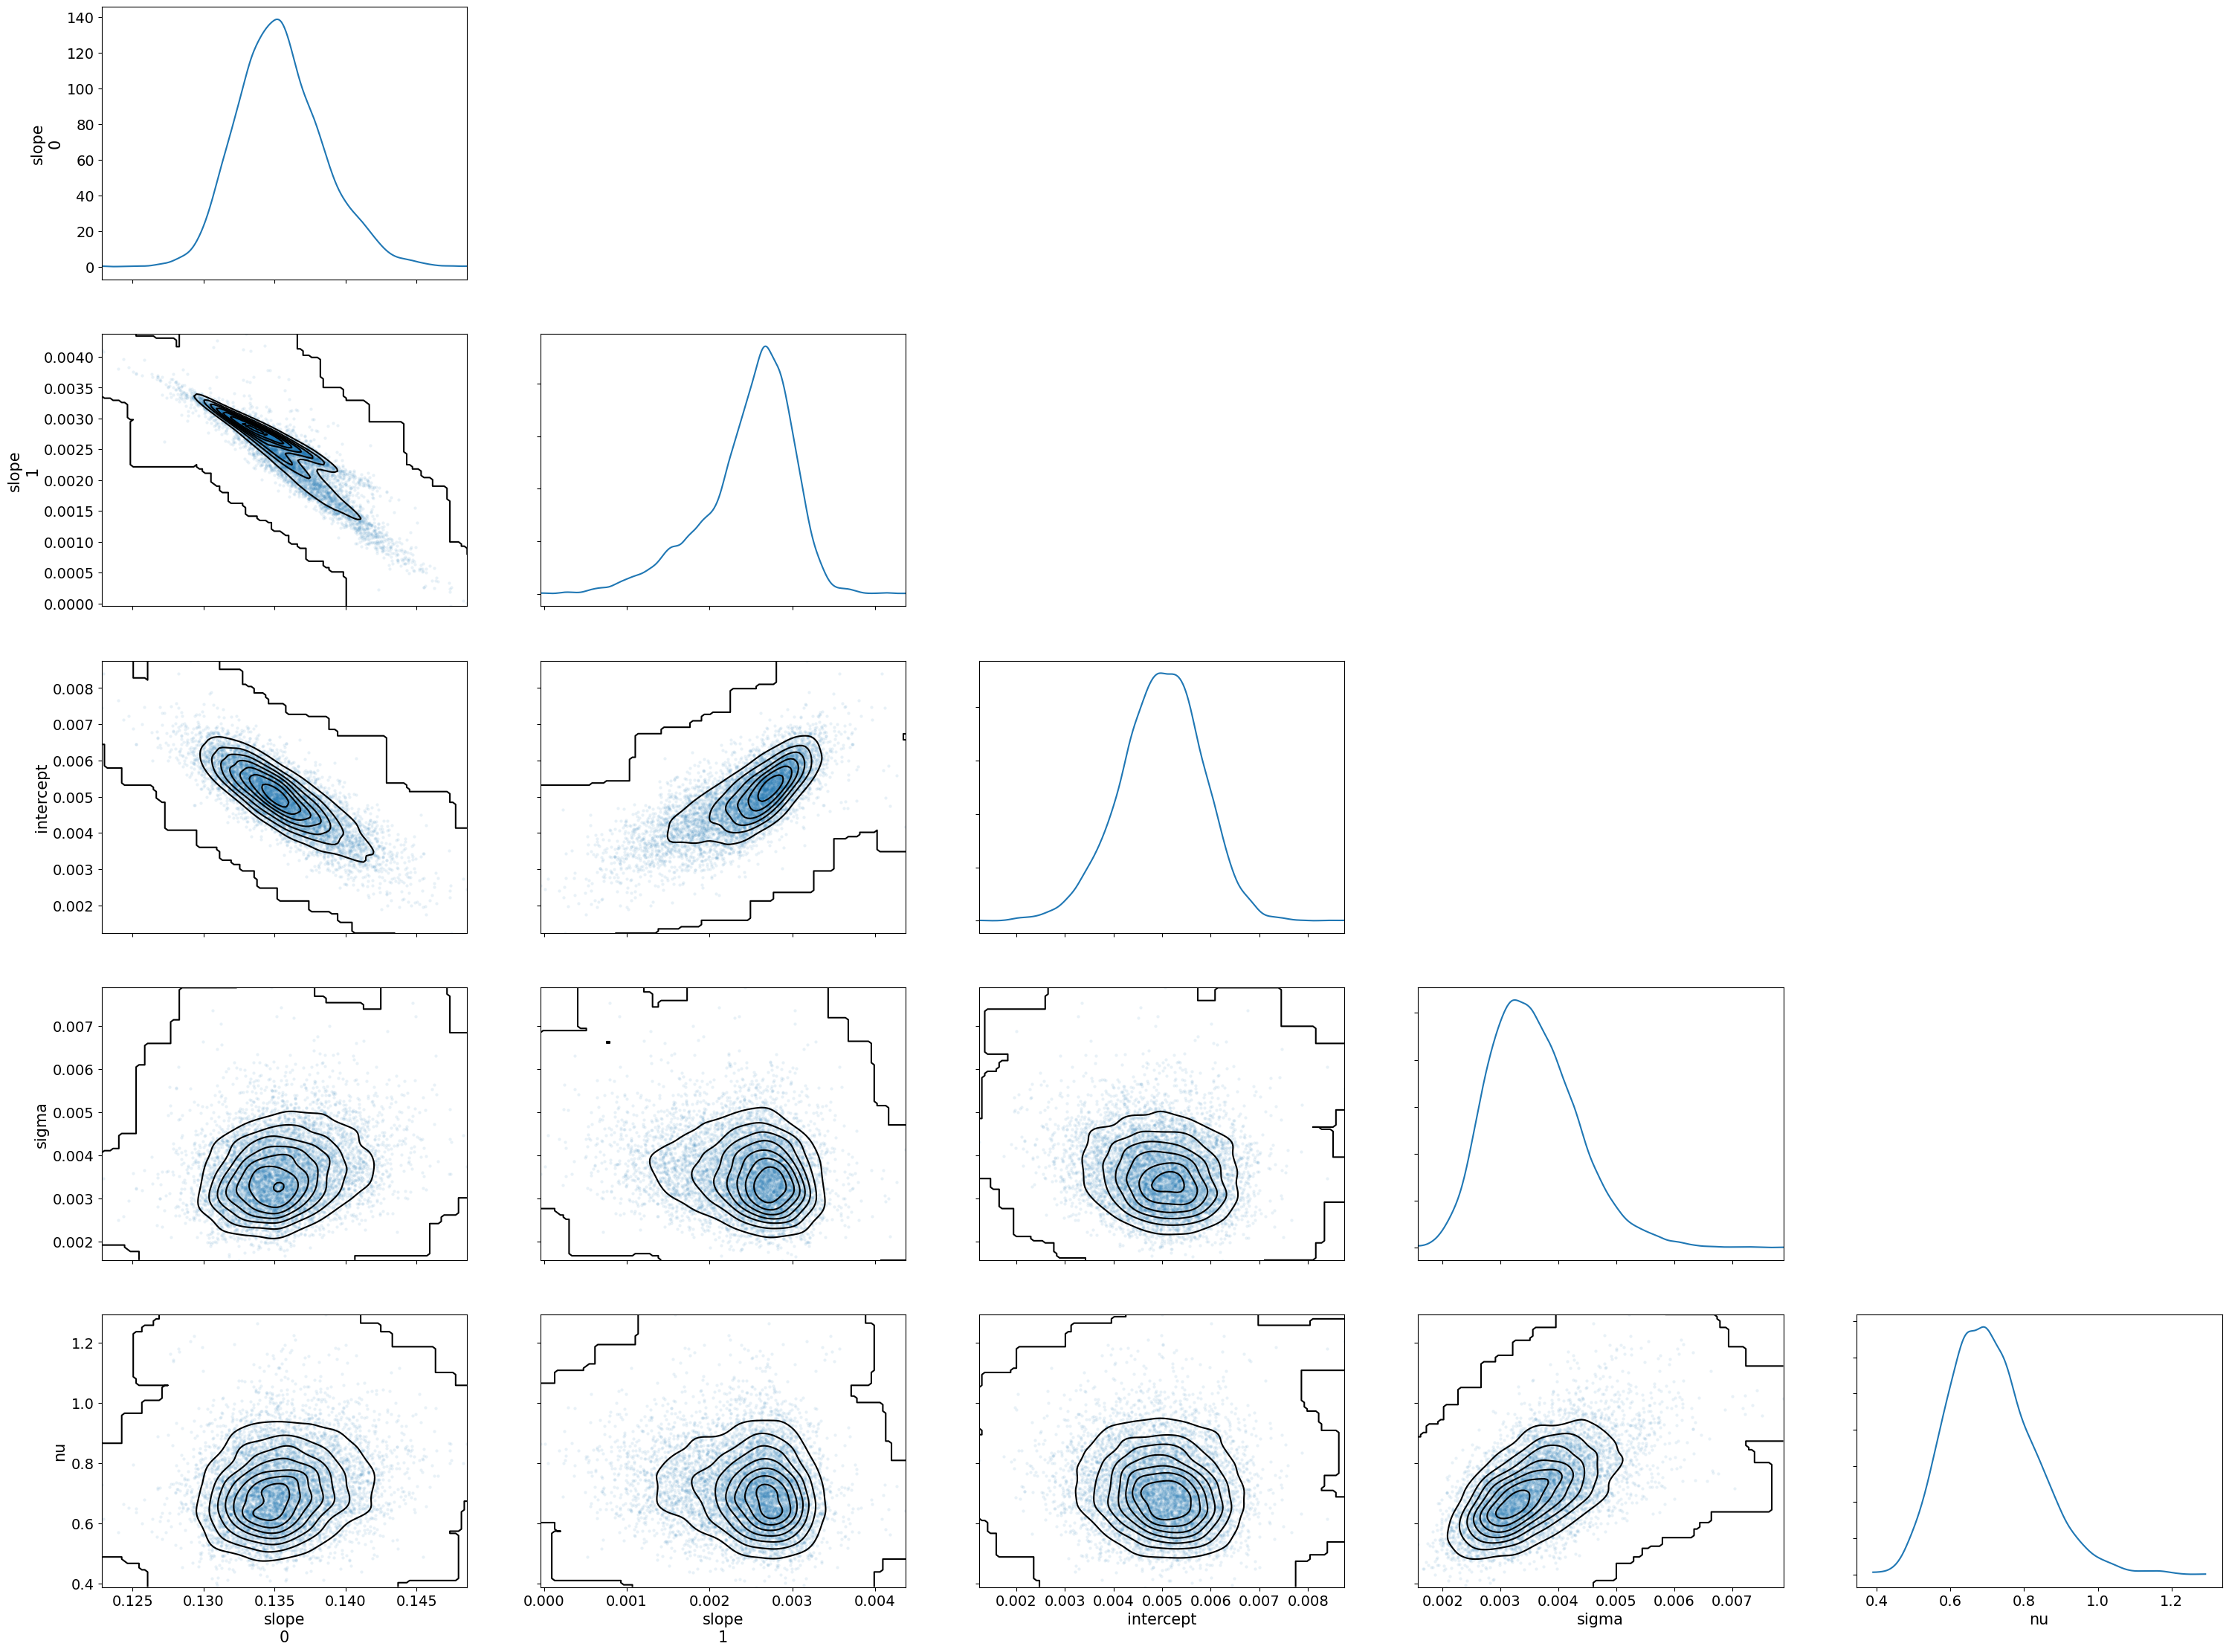

In [37]:
plot_diagnostics (studentT_quadratic_model, studentT_quadratic_inference)

### Student T cubic model

In [38]:
print('Fitting Student T cubic model')
with pm.Model() as studentT_cubic_model:
    intercept = pm.HalfNormal('intercept', sigma=0.1)
    slope = pm.Normal('slope', mu=0.6, sigma=0.3, shape = 3)
    sigma = pm.Uniform('sigma', lower=0, upper=0.5)
    # Degrees of freedom for the Student's t-distribution
    nu = pm.HalfNormal('nu', sigma=30)
    # Mutable data for the observed variables
    x = pm.MutableData('revenue', data_x)
    y = pm.MutableData('wage', data_y)

    mu = pm.Deterministic('mu', intercept + slope[0] * x + slope[1] * x**2 + slope[2] * x**3)
    y = pm.StudentT('likelihood', nu=nu, mu=mu, sigma=sigma, observed=y)
    studentT_cubic_inference = pm.sample(2000,tune=6000, \
                                        target_accept=0.97, random_seed= 42, \
                                        return_inferencedata=True, \
                                        idata_kwargs={"log_likelihood": True})

Fitting Student T cubic model


/Users/macbook/anaconda3/lib/python3.11/site-packages/pymc/data.py:317: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
slope[0]   0.119  0.005   0.111    0.128      0.000    0.000    1580.0   
slope[1]   0.015  0.002   0.012    0.018      0.000    0.000    1291.0   
slope[2]  -0.002  0.000  -0.002   -0.001      0.000    0.000    1287.0   
intercept  0.008  0.001   0.006    0.010      0.000    0.000    1782.0   
sigma      0.004  0.001   0.002    0.005      0.000    0.000    2754.0   
nu         0.809  0.136   0.570    1.071      0.003    0.002    2968.0   

           ess_tail  r_hat  
slope[0]     2592.0   1.00  
slope[1]     1901.0   1.01  
slope[2]     1821.0   1.01  
intercept    2656.0   1.00  
sigma        3469.0   1.00  
nu           3870.0   1.00  


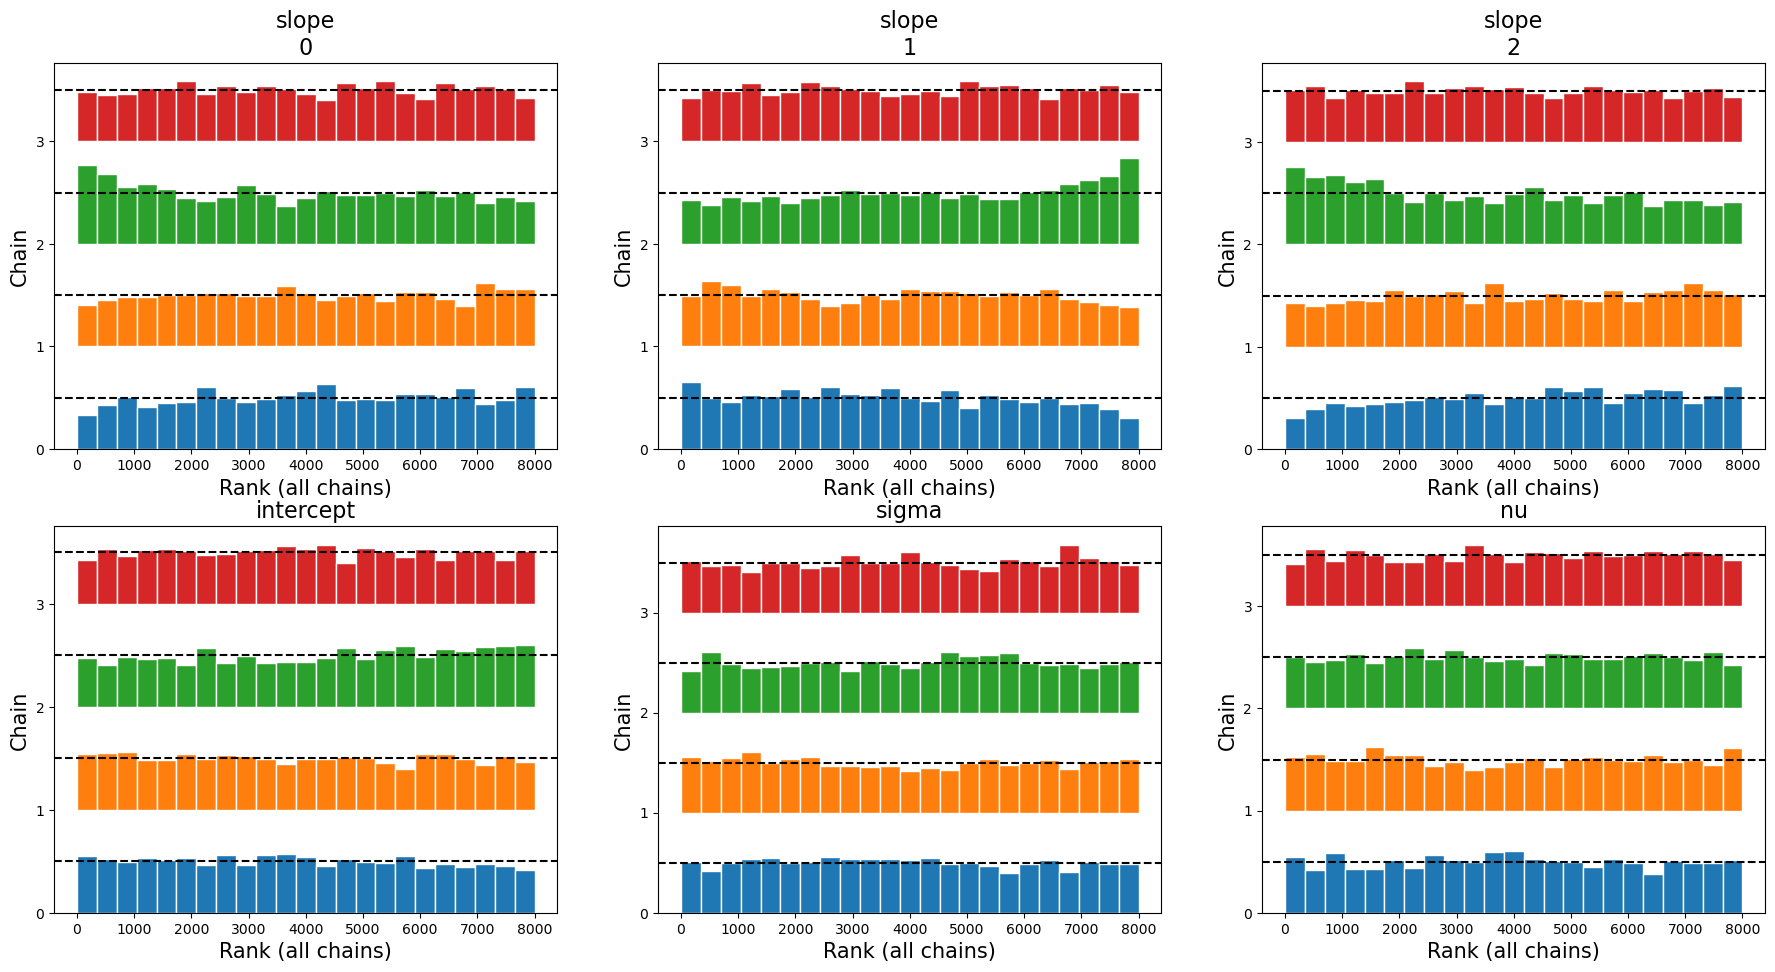

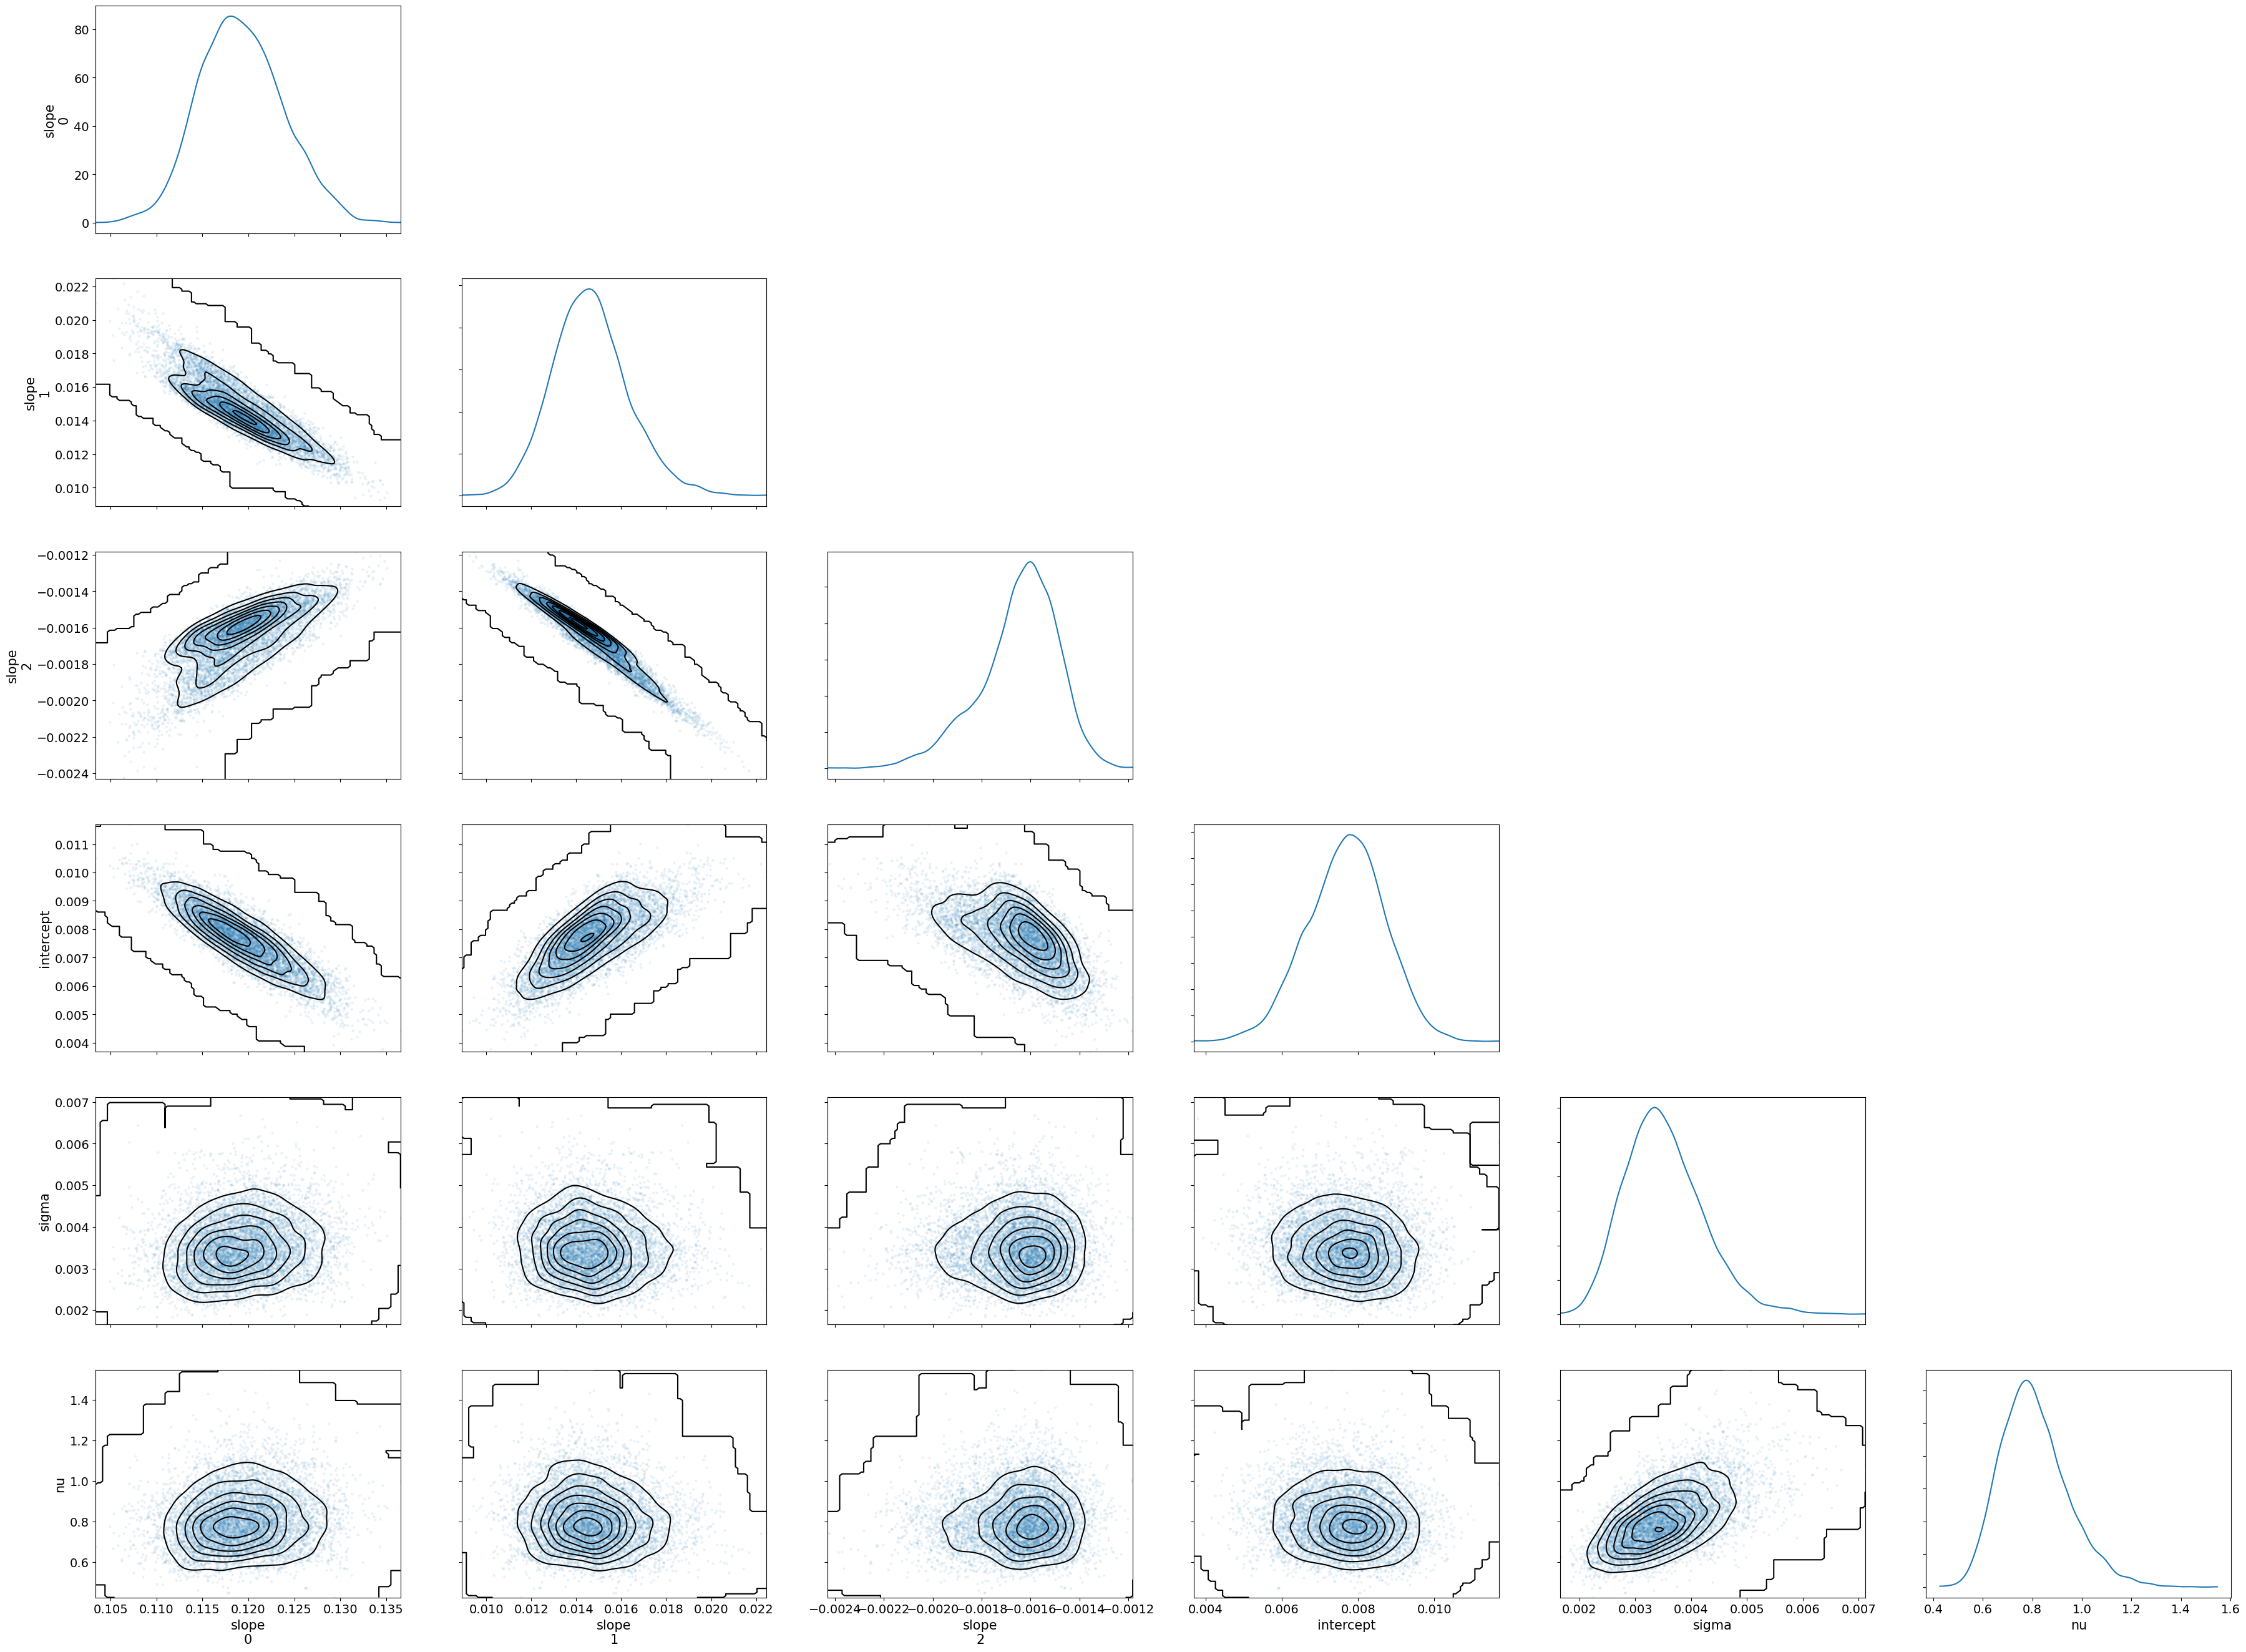

In [39]:
plot_diagnostics (studentT_cubic_model, studentT_cubic_inference)

# Posterior distribution of parameters


## Linear models

The range for the intercept posteriors also shifts from a wide range [0 - 0.03] to [0 - 0.005]. This is because when the slope posterior increases (as explained above), the intercept must adjust downward to keep the line closer to the data points. This adjustment helps balance the overall fit across the range of x values.

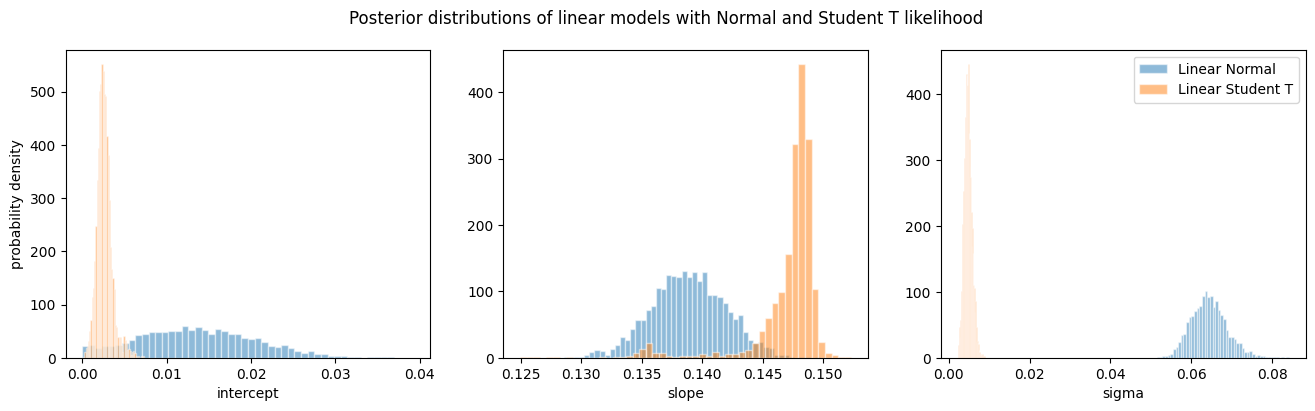

In [ ]:
plt.figure(figsize=(16, 4))
plt.suptitle('Posterior distributions of linear models with Normal and Student T likelihood')
for i, var in enumerate(['intercept', 'slope', 'sigma']):
    plt.subplot(1, 3, i+1)
    plt.xlabel(var)
    if i == 0:
        plt.ylabel('probability density')
    plt.hist(getattr(normal_linear_inference.posterior, var).values.flatten(), density=True, bins=50, edgecolor='white', alpha=0.5, label='Linear Normal')
    plt.hist(getattr(studentT_linear_inference.posterior, var).values.flatten(), density=True, bins=50, edgecolor='white', alpha=0.5, label='Linear Student T')
plt.legend()
plt.show()

## Quadratic models

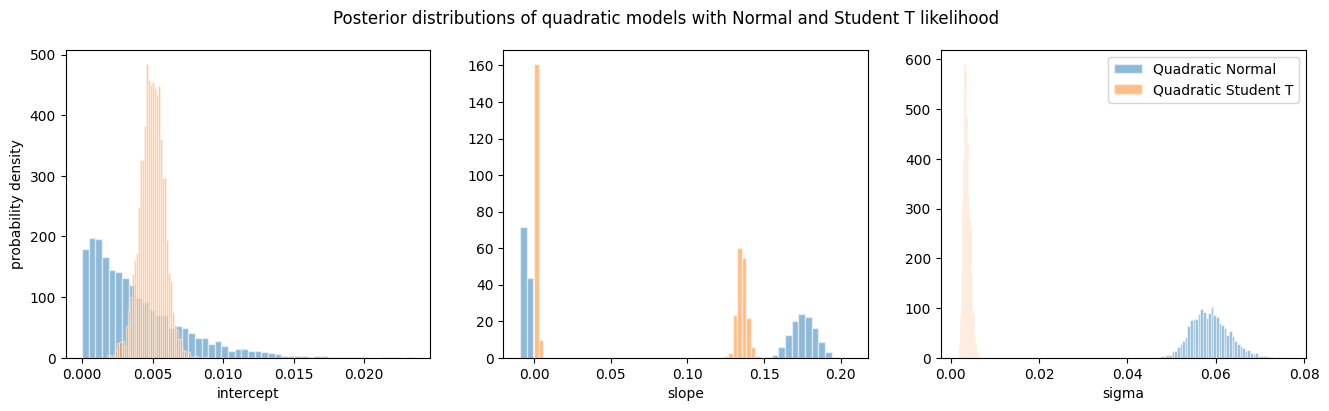

In [ ]:
plt.figure(figsize=(16, 4))
plt.suptitle('Posterior distributions of quadratic models with Normal and Student T likelihood')
for i, var in enumerate(['intercept', 'slope', 'sigma']):
    plt.subplot(1, 3, i+1)
    plt.xlabel(var)
    if i == 0:
        plt.ylabel('probability density')
    plt.hist(getattr(normal_cubic_inference.posterior, var).values.flatten(), density=True, bins=50, edgecolor='white', alpha=0.5, label='Quadratic Normal')
    plt.hist(getattr(studentT_cubic_inference.posterior, var).values.flatten(), density=True, bins=50, edgecolor='white', alpha=0.5, label='Quadratic Student T')
plt.legend()
plt.show()

## Cubic models

In [45]:
plt.figure(figsize=(16, 4))
plt.suptitle('Posterior distributions of linear models with Normal and Student T likelihood')
for i, var in enumerate(['intercept', 'slope', 'sigma']):
    plt.subplot(1, 3, i+1)
    plt.xlabel(var)
    if i == 0:
        plt.ylabel('probability density')
    plt.hist(getattr(normal_cubic_inference.posterior, var).values.flatten(), density=True, bins=50, edgecolor='white', alpha=0.5, label='Cubic Normal')
    plt.hist(getattr(studentT_cubic_inference.posterior, var).values.flatten(), density=True, bins=50, edgecolor='white', alpha=0.5, label='Cubic Student T')
plt.legend()
plt.show()

# Posterior predictive check

In [46]:
def plot_posterior_predictive (model, inference, name):
    with model:
      # Generate posterior predictive checks
      posterior_pred = pm.sample_posterior_predictive(inference, extend_inferencedata=True)
    plt.figure(figsize=(8, 6))
    plt.title(f'Posterior and posterior-predictive distributions of {name}')
    az.plot_hdi(
        data_x, inference.posterior_predictive.likelihood,
        hdi_prob=0.95, smooth=False, color='C1',
        fill_kwargs={'alpha': 0.2, 'label': 'posterior-predictive 95% HDI'})
    az.plot_hdi(
        data_x, inference.posterior.mu,
        hdi_prob=0.95, smooth=False, color='C1',
        fill_kwargs={'alpha': 0.4, 'label': 'posterior $\mu$ 95% HDI'})
    plt.plot(
        data_x, inference.posterior.mu.mean(dim=['chain', 'draw']).values,
        color='C1', alpha=1, label='posterior $\mu$ mean')
    plt.plot(data_x, data_y, 'o', alpha=0.33, color='C0', label='data')
    plt.xlabel("Wage (Trillions pesos)")
    plt.ylabel("Total revenue (Trillions pesos)")
    plt.legend()

Output()

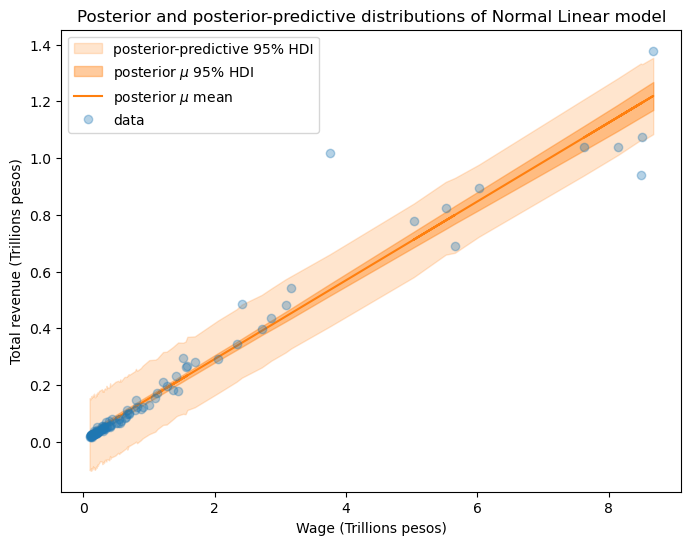

In [47]:
plot_posterior_predictive (normal_linear_model, normal_linear_inference, 'Normal Linear model')

Output()

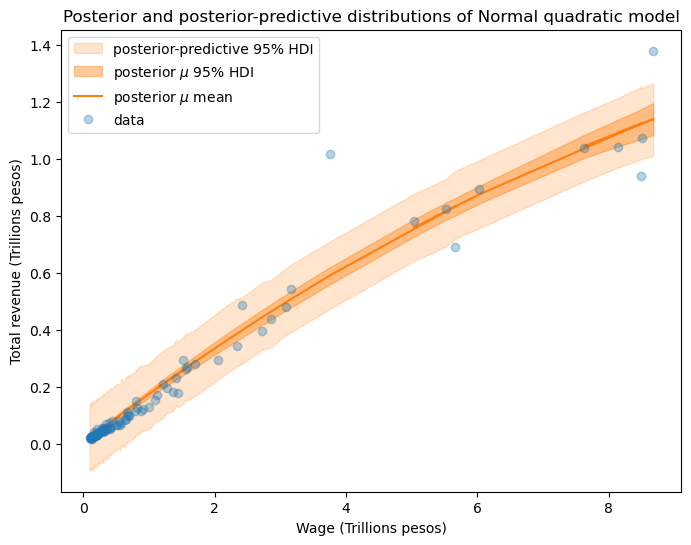

In [48]:
plot_posterior_predictive (normal_quadratic_model, normal_quadratic_inference, 'Normal quadratic model')

In [49]:
plot_posterior_predictive (normal_cubic_model, normal_cubic_inference, 'Normal cubic model')

Output()

In [50]:
plot_posterior_predictive (studentT_linear_model, studentT_linear_inference, 'Student T linear model')

Output()

Output()

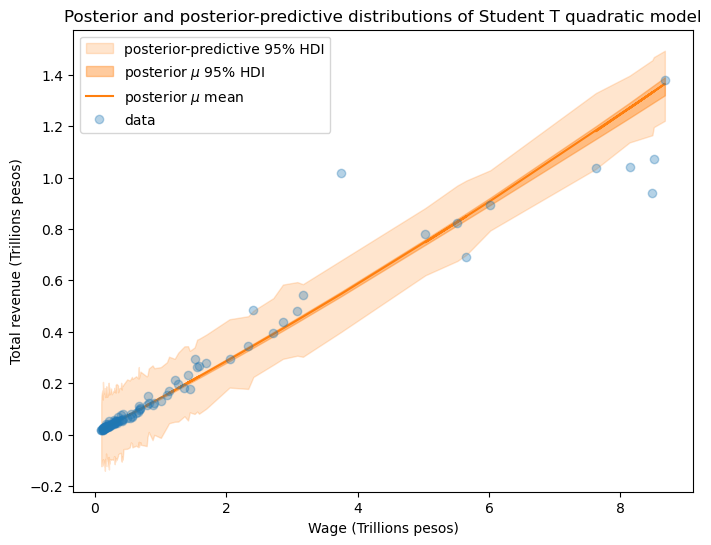

In [51]:
plot_posterior_predictive (studentT_quadratic_model, studentT_quadratic_inference, 'Student T quadratic model')

In [52]:
plot_posterior_predictive (studentT_cubic_model, studentT_cubic_inference, 'Student T cubic model')

Output()

# MODEL COMPARISON

In [64]:
comparison = az.compare(
    {'Normal Linear Model': normal_linear_inference,\
     'Normal Quadratic Model': normal_quadratic_inference,\
     'Normal Cubic Model': normal_cubic_inference,
     'Student T Linear Model': studentT_linear_inference,\
     'Student T Quadratic Model': studentT_quadratic_inference,\
     'Student T Cubic Model': studentT_cubic_inference},\
     ic='loo', scale='log')
display(comparison)
az.plot_compare(comparison, legend=True, insample_dev = True, plot_standard_error = True, plot_ic_diff = True)

/Users/macbook/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/macbook/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/macbook/anaconda3/lib/python3.11/site-packages/arvi

rank    elpd_loo      p_loo   elpd_diff  \
Student T Cubic Model         0  289.283942  15.890006    0.000000   
Student T Quadratic Model     1  270.169622  10.189977   19.114319   
Student T Linear Model        2  262.391333  11.692182   26.892609   
Normal Quadratic Model        3  134.871541  24.768056  154.412400   
Normal Cubic Model            4  130.646143  29.983354  158.637799   
Normal Linear Model           5  125.259327  22.550766  164.024615   

                                 weight         se        dse  warning scale  
Student T Cubic Model      8.019814e-01  19.875188   0.000000    False   log  
Student T Quadratic Model  1.552471e-01  21.315887  10.737382    False   log  
Student T Linear Model     0.000000e+00  19.767382   9.875898     True   log  
Normal Quadratic Model     4.277152e-02  38.049348  32.114909     True   log  
Normal Cubic Model         0.000000e+00  39.821883  33.118098     True   log  
Normal Linear Model        6.313172e-12  39.966893  34.720120     True   log

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

## Point wise outlier detection

/Users/macbook/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


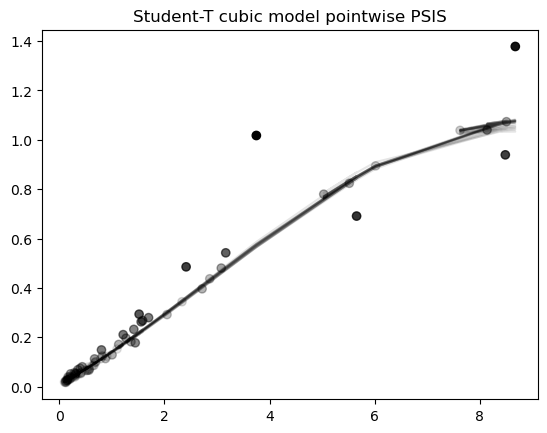

In [67]:
plt.figure()
plt.title('Normal quadratic model pointwise PSIS')
weights = az.loo(normal_quadratic_inference, pointwise=True).loo_i.values
alpha = 1 - 0.95 * (weights - weights.min()) / (weights.max() - weights.min())
plt.scatter(data_x, data_y, color='black', alpha=alpha)
plt.plot(data_x, normal_quadratic_inference.posterior.mu[0, :20, :].transpose(), 'k-', alpha=0.1)

plt.figure()
plt.title('Student-T cubic model pointwise PSIS')
weights = az.loo(studentT_cubic_inference, pointwise=True).loo_i.values
alpha = 1 - 0.95 * (weights - weights.min()) / (weights.max() - weights.min())
plt.scatter(data_x, data_y, color='black', alpha=alpha)
plt.plot(data_x, studentT_cubic_inference.posterior.mu[0, :20, :].transpose(), 'k-', alpha=0.1)
plt.show()

AI tools: I first use ChatGPT by pasting the assignment prompts and generate a checklist of tasks I need to do. I use it double check and adapt the code from the class.